# **Smart Home Sensor Data Analysis: Impact on Elderly Activity Levels**

This notebook analyzes smart home sensor data to understand how environmental factors influence the activity levels of elderly residents. The insights from this EDA will inform feature engineering and the selection of a machine learning model.

**Analysis Workflow:**

1. **Data Inspection:** Initial review of the dataset's structure, data types, and basic statistics to identify anomalies and missing values.
2. **Data Cleaning:** Preprocessing the data by removing duplicates, standardizing formats, imputing missing values, and filtering out erroneous or impossible sensor readings.
3. **Multivariate Analysis:** Exploring the relationships and interactions between different environmental sensors and their collective impact on activity levels.

## **Load Data**

In [1]:
#import packages
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from itertools import combinations
from scipy.stats import chi2_contingency , f_oneway

In [2]:
#Connect sqlite3 database
conn = sqlite3.connect("data/gas_monitoring.db")

#load data to dataframe
df = pd.read_sql_query("SELECT * FROM gas_monitoring",conn)

## **1. Inspect Data**

---
### Step 1:  
We start by inspecting the structure and completeness of our dataset , Then, we study the summary statistics of the dataset to potentially uncover any anomalies. Finally, we compute the number of missing values for each columns for easier reference. 

**Purpose:**  
This helps us quickly see how many rows/columns we have, the types of data, any anomalies and whether any columns have missing values and if so, how large of a missing data we are dealing with. 

We use this information to plan data cleaning and understand what issues we will need to address.

---

In [3]:
#Show basic info
print("=== DataFrame Info ===")
df.info()

#Show summary stats for numerical data
print("\n\n=== Summary Statistics ===")
display(round(df.describe(),2))

print("\n\n=== Missing Values by Column ===")
#show missing values
df.isnull().sum()

=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time of Day                10000 non-null  object 
 1   Temperature                10000 non-null  float64
 2   Humidity                   10000 non-null  float64
 3   CO2_InfraredSensor         10000 non-null  float64
 4   CO2_ElectroChemicalSensor  9294 non-null   float64
 5   MetalOxideSensor_Unit1     10000 non-null  float64
 6   MetalOxideSensor_Unit2     10000 non-null  float64
 7   MetalOxideSensor_Unit3     7434 non-null   float64
 8   MetalOxideSensor_Unit4     10000 non-null  float64
 9   CO_GasSensor               8631 non-null   object 
 10  Session ID                 10000 non-null  int64  
 11  HVAC Operation Mode        10000 non-null  object 
 12  Ambient Light Level        7468 non-null   object 
 13  Activity Level          

,Temperature,Humidity,CO2_InfraredSensor,CO2_ElectroChemicalSensor,MetalOxideSensor_Unit1,MetalOxideSensor_Unit2,MetalOxideSensor_Unit3,MetalOxideSensor_Unit4,Session ID
count,10000.00,10000.00,10000.00,9294.00,10000.00,10000.00,7434.00,10000.00,10000.00
mean,42.56,51.13,110.36,578.33,470.36,728.27,681.36,611.96,5418.64
std,74.35,20.57,25.06,22.67,51.35,43.30,59.99,42.86,2588.47
min,14.94,-49.66,-14.67,408.60,286.83,554.28,457.81,412.79,1374.00
25%,19.00,47.68,99.08,559.22,439.63,707.96,658.22,585.55,3074.00
50%,20.53,51.30,113.10,578.89,468.81,726.64,680.08,609.00,5214.00
75%,23.13,53.85,124.02,595.18,493.94,746.49,704.40,635.48,7395.00
max,298.93,199.59,236.01,637.90,632.89,902.21,905.15,736.11,9658.00




=== Missing Values by Column ===


Time of Day                     0
Temperature                     0
Humidity                        0
CO2_InfraredSensor              0
CO2_ElectroChemicalSensor     706
MetalOxideSensor_Unit1          0
MetalOxideSensor_Unit2          0
MetalOxideSensor_Unit3       2566
MetalOxideSensor_Unit4          0
CO_GasSensor                 1369
Session ID                      0
HVAC Operation Mode             0
Ambient Light Level          2532
Activity Level                  0
dtype: int64

---
**Comments:**

1) The dataset has 10,000 records and 14 columns.

2) We have 5 categorical features: `Time of Day`,`CO_GasSensor`,`HVAC Operation Mode`,`Ambient Light Level`,`Activity Level`

3) `CO2_ElectroChemicalSensor`,`MetalOxideSensor_Unit3`,`CO_GasSensor`,`Ambient Light Level` contains missing values which needs to be resolved.

4) Potential changes based on summary statistics:
   - `Temperature` detected a max value of ~299dgC which is an anomaly considering the ambient temperature fits more to the median which was only ~20dgC 
   - `Humidity` detected negative value from min which is not possible, and too high of a value from max which is unlikely.
   - `CO2_InfraredSensor` detected negative value from min which is not possible for a concentration measurement.

5) `MetalOxideSensor_Unit3` and `Ambient Light Level` has about 25% missing values , which i think should try to retain to prevent data loss if possible.

---

### Step 2:

This step is to examine the unique data point of each categorical features to:
1) Understand what values are there and whether it make sense
2) See if theres any formatting issues

---

In [4]:
#Examine unique values for each categorical variables
for col in df.select_dtypes(include='object').columns:
    uniques = sorted(df[col].dropna().unique(),key=str.lower)
    print(f"{col} : {uniques}\n")

Time of Day : ['afternoon', 'evening', 'morning', 'night']

CO_GasSensor : ['extremely high', 'extremely low', 'high', 'low', 'medium']

HVAC Operation Mode : ['cooling_active', 'Cooling_Active', 'COOLING_ACTIVE', 'Cooling_active', 'eco_mode', 'Eco_Mode', 'Eco_mode', 'ECO_MODE', 'Heating_active', 'heating_active', 'HEATING_ACTIVE', 'Heating_Active', 'maintenance_mode', 'MAINTENANCE_MODE', 'Maintenance_mode', 'Maintenance_Mode', 'off', 'Off', 'OFF', 'ventilation_only', 'VENTILATION_ONLY', 'Ventilation_Only', 'Ventilation_only']

Ambient Light Level : ['bright', 'dim', 'moderate', 'very_bright', 'very_dim']

Activity Level : ['High Activity', 'Low Activity', 'Low_Activity', 'LowActivity', 'Moderate Activity', 'ModerateActivity']



**Comments:**
1) `HVAC Operation Mode` seems to have similar categories with many different formats; will need to standardise them subsequently.

2) `Activity Level` also has similar categories with different formats ; some with or without space or underscores that needs to be standardised.

---

### Step 3:
This step is to visualise the distribution of our data so that:

1) It is easier to detect outliers.

2) Understand the distribution of each feature for downstream purposes like:
   - Data imputation
   - Transformation
   - Model selection
   - Identify class imbalance
---

Generating charts for numerical columns...


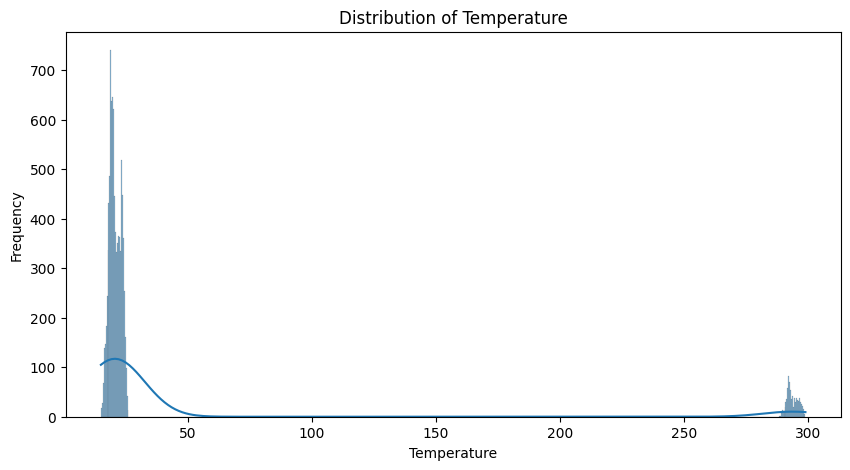

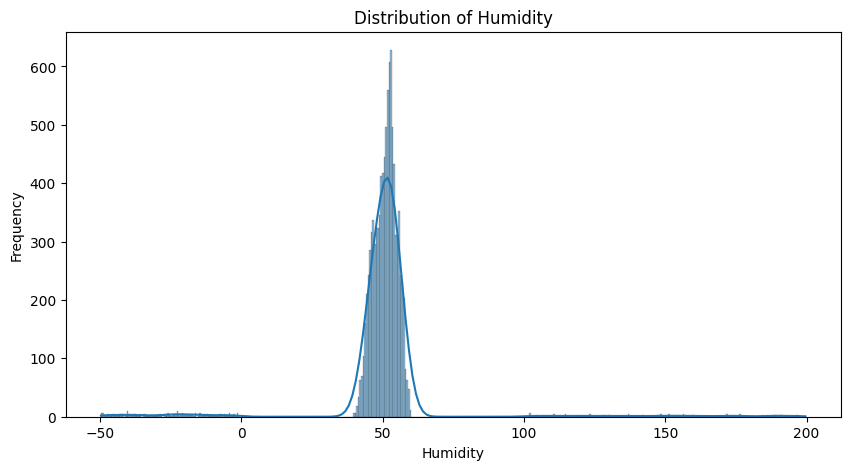

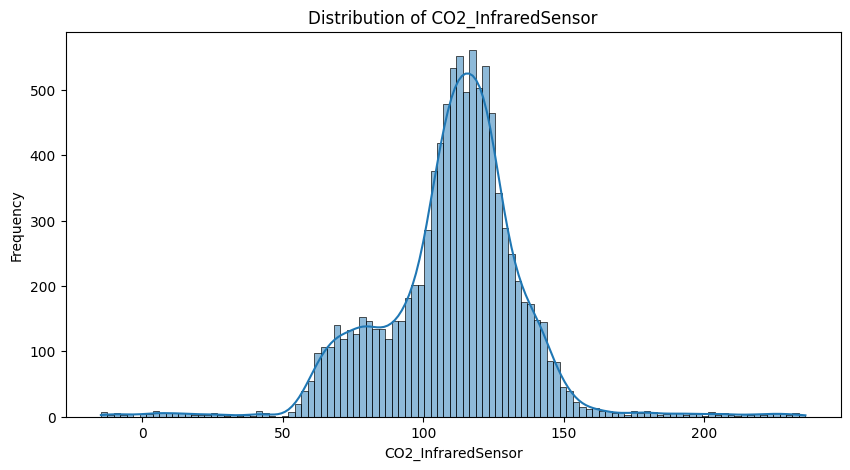

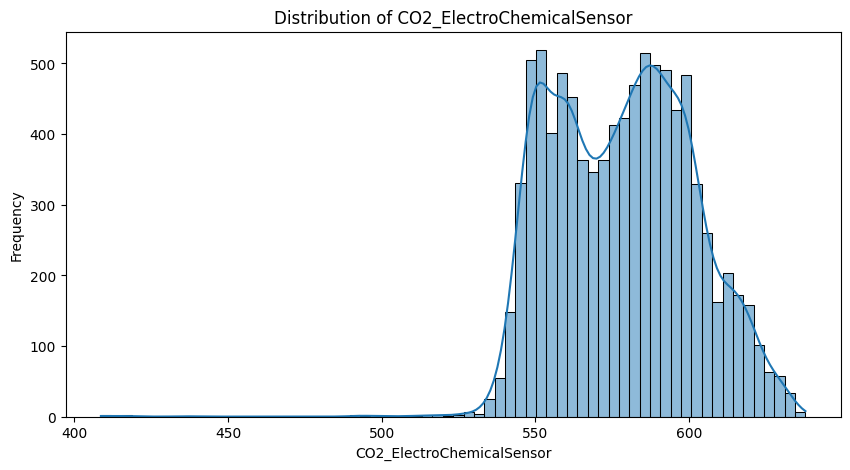

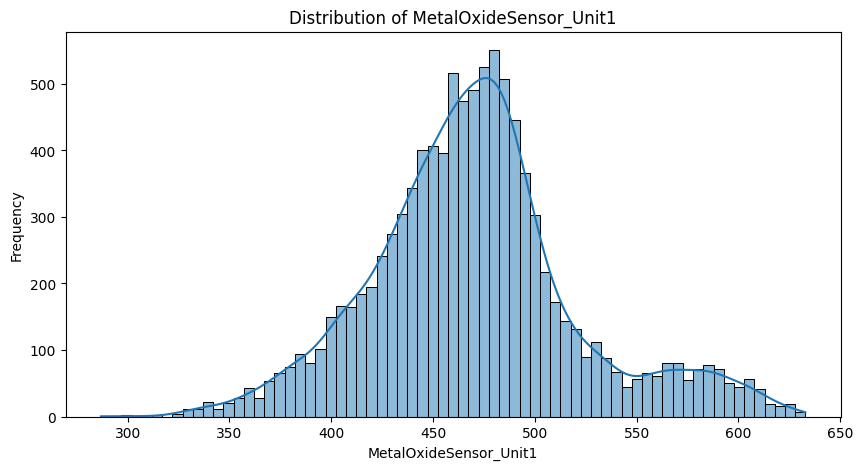

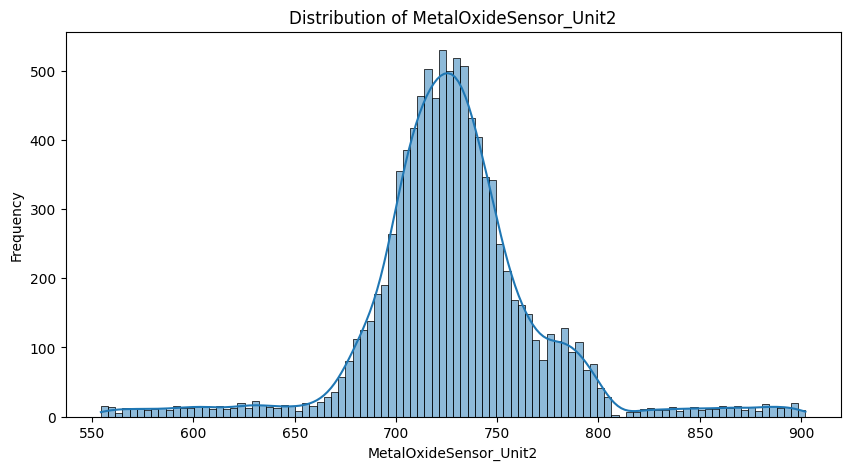

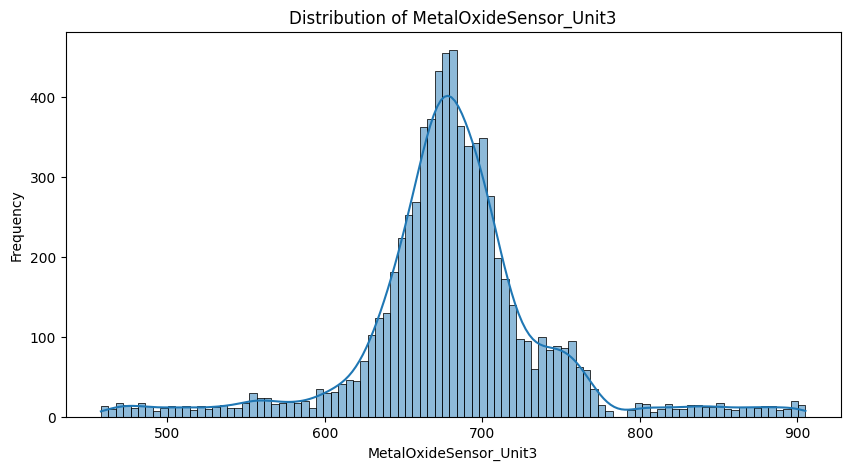

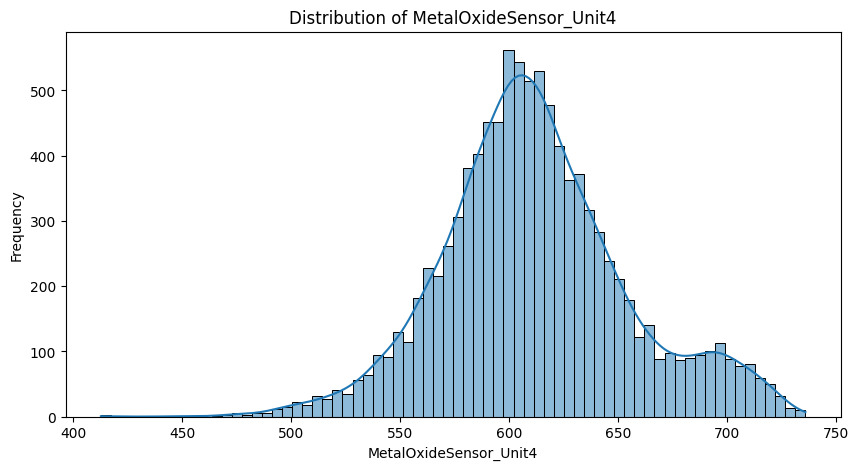

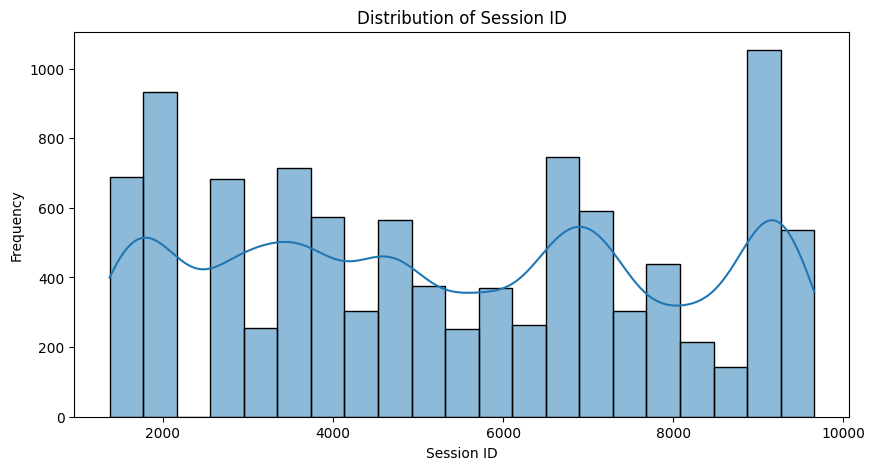


Generating charts for categorical columns...


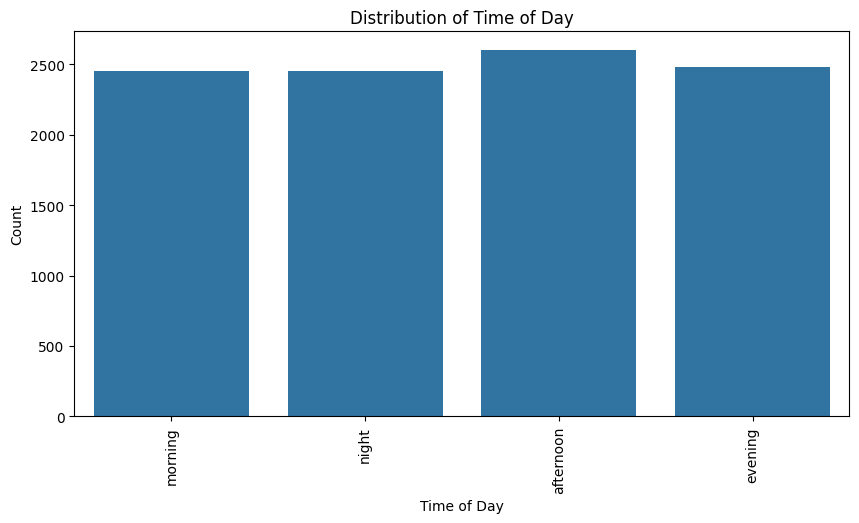

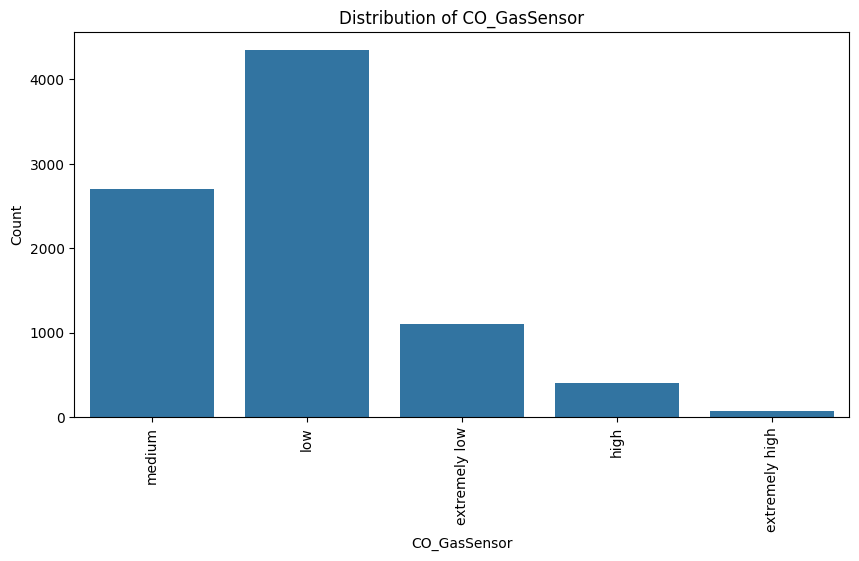

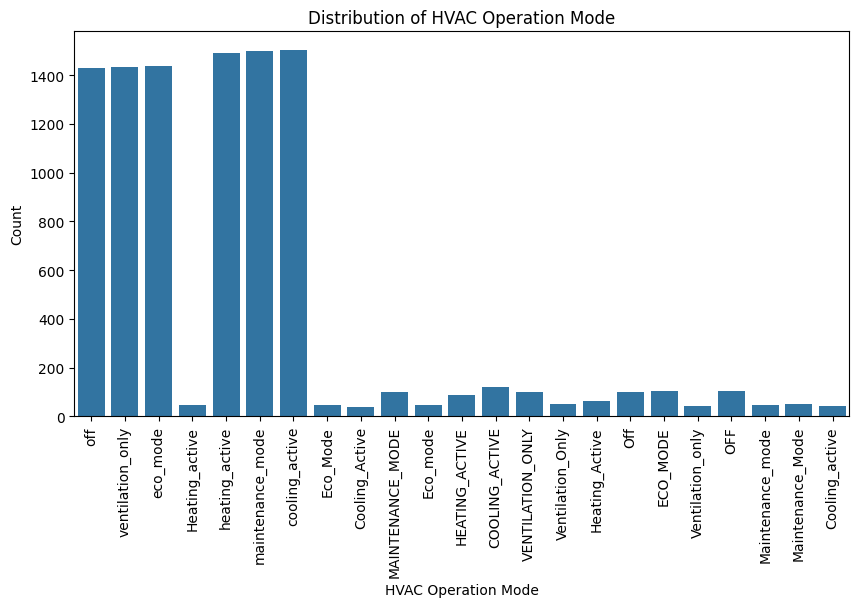

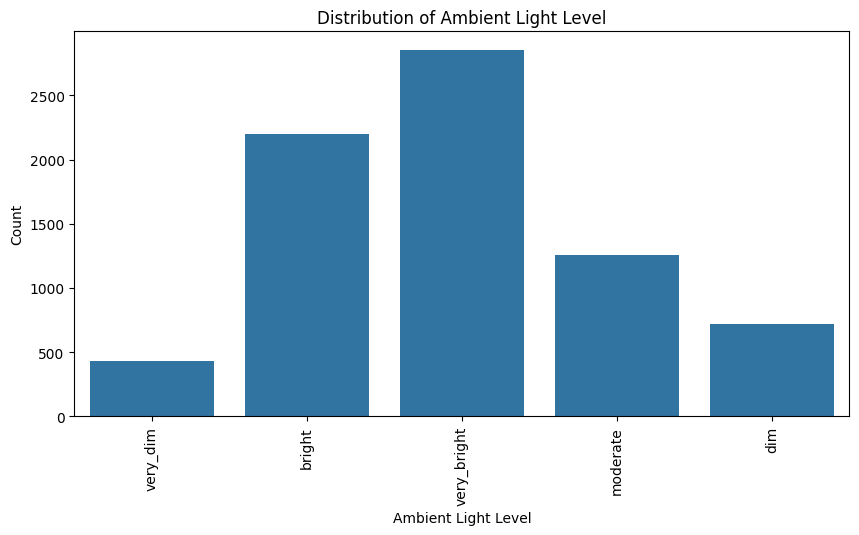

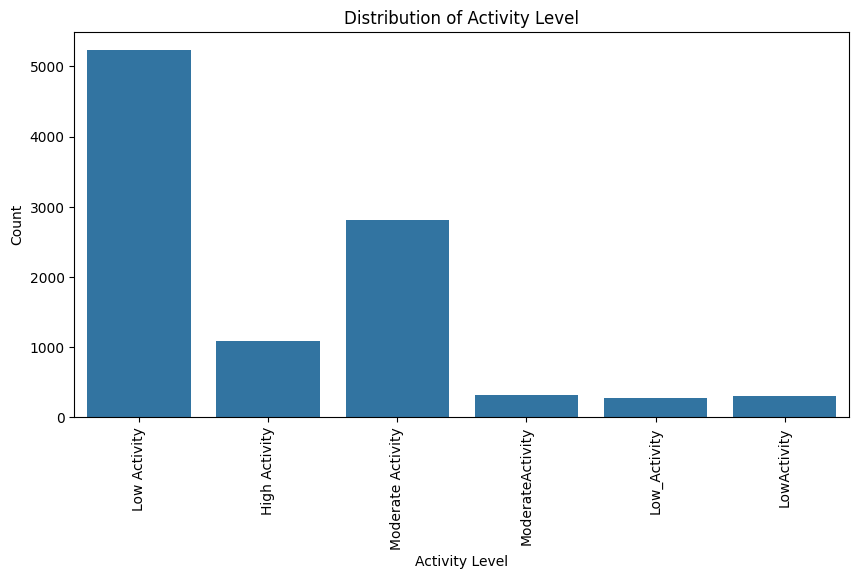

In [5]:
#Create function to plot the distributions 
def plot_distributions(df):
    
    # Get numerical and categorical columns from df
    num = df.select_dtypes(include=np.number).columns
    cat = df.select_dtypes(include='object').columns
    
    # Plot distributions for numerical columns
    print("Generating charts for numerical columns...")
    for col in num:
        plt.figure(figsize=(10, 5))
        sns.histplot(df[col], kde=True, bins="auto")
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
            
    # Plot distributions for categorical columns
    print("\nGenerating charts for categorical columns...")
    for col in cat:
        plt.figure(figsize=(10, 5))
        sns.countplot(x=col, data=df)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

#visualise
plot_distributions(df)  


**Comments:**

---
**Numeric:**
1) `Temperature` shows 2 distinct groups , bulk of it lies within 0-50dgC while small part of the data shows close to 300dgC.

2) `Humidty` distribution looks leptokurtic

3) `CO2_InfraredSensor` is roughly normal with a slight right-skew.

4) `CO2_ElectroChemicalSensor` is bimodal and right-skewed, suggesting 2 kinds of underlying conditions that result in 2 distinct peaks.

5) All 4 Metal Oxide Sensors (MOS) generally shows a normal and right-skewed distribution with some outliers.

6) `Session ID` seems to be random and not meaningful; will drop this column.

---

**Categorical:**
1) `Time of Day` seems to be evenly distributed with afternoon being slightly higher than the rest.

2) The `CO_GasSensor` feature is heavily skewed towards the "low" and "medium" categories, and very few "high" or "extremely high", suggesting class imbalance and should take further consideration during modeling, especially if rare high values are critical for detection or alerts.

3) Due to incorrect format, the distribution of `HVAC Operation Mode` are mostly sparsed. This should be fixed subsequently.

4) The `Ambient Light Level` feature is skewed toward "very_bright" and "bright" , indicating that most sensor readings were taken in well-lit environments, possibly during the day or in actively used rooms. The relative scarcity of "dim" and "very_dim" values may reflect nighttime or low-activity periods, which should be considered in downstream analysis or modeling.

5) `Activity Level` variable is highly imbalanced, with "Low Activity" being the most frequent class, several similar classes are present due to formatting issue and should be consolidated during data cleaning. The imbalance should be considered during modeling, as models may be biased toward the low activity class.

   
---

## <b> 2. Data Cleaning  <b>

---
**Purpose:**

The primary goal of this section is to correct or remove inaccurate, incomplete, or irrelevant data. This ensures the dataset's consistency, reliability, and accuracy, which is crucial for any subsequent analysis or machine learning modeling.

**Key Steps:**

1. **Remove Duplicates:**
    - Eliminates redundant data to prevent bias.
2. **Reformat Categorical Data:**
    - Standardizes inconsistent text data

3. **Handle Missing Values (Imputation):**
   - Machine learning models typically cannot handle missing values. Imputation fills these gaps with reasonable estimates, allowing us to use the full dataset without introducing significant bias.


4. **Exclude Unreasonable Data (Filtering):**
   - Sensor data can contain errors that are physically impossible (e.g., negative humidity). These outliers can distort the results of our analysis and the accuracy of our models.


---

In [6]:
#1.Remove duplicates
df = df.drop_duplicates()

display(df.shape)

(9880, 14)

In [7]:
#2.Reformat and condense data for HVAC operation modes
df["HVAC Operation Mode"] = df["HVAC Operation Mode"].map(lambda x: x.lower() if isinstance(x, str) else x)

In [8]:
#3.Reformat and condense data for activity level
def clean_activity_string(value):

    #make all values lower case
    value = value.lower()

    #create space between xxx activity
    value = re.sub(r"(\w)activity",r"\1 activity",value,flags= re.IGNORECASE) 

    #replace space with underscore
    value = re.sub(r"[\s_]+","_",value) 
    return value

#apply replacement to activity level
df["Activity Level"] = df["Activity Level"].apply(clean_activity_string)

In [9]:
#4.Impute values based on observed distribution for categorical variables
def impute_cat_data(df,col_name):
    #get distribution of categorical values
    dist = df[col_name].value_counts(normalize=True) 
    
    #mask rows with missing values
    miss_rows = df[col_name].isnull()
    
    #Fill missing values
    df.loc[miss_rows,col_name] = np.random.choice(dist.index,size=miss_rows.sum(),p=dist.values) 
    
    return df

#Define features for imputation
cols = ["CO_GasSensor" , "Ambient Light Level"]

for i in cols:
    impute_cat_data(df,i)

In [10]:
#4.Impute values based on observed distribution for numerical variables
def impute_con_data(df,col_name):
    
    #Get non-null values
    valid = df[col_name].dropna()
    
    #Sample randomly from the valid values
    num_missing = df[col_name].isnull().sum()
    imputed_values = valid.sample(num_missing, replace=True)
    
    #Fill NaNs with sampled values
    df.loc[df[col_name].isnull(),col_name] = imputed_values.values

    return df

#Impute for MOS unit 3
df = impute_con_data(df,"MetalOxideSensor_Unit3")

In [11]:
#5.Exclude unreasonable data

#Set different thresholds
temp_max = 50                 #set fixed upper threshold for temp 
RH_min,RH_max = 0 , 100       #RH intuitively should be 0-100
CO2_IS_min = 0                #Gas concentration level should be <0
CO2_ECS_threshold = 500       #Keep values nearer to distribution


df = df[
    (df["Temperature"] < temp_max) &
    (df["Humidity"].between(RH_min, RH_max)) &
    (df["CO2_InfraredSensor"] > CO2_IS_min) &
    (df["CO2_ElectroChemicalSensor"] > CO2_ECS_threshold)
]

display(df.shape)

(7983, 14)


**Comments:**

1. **Duplicate Removal:**
- Duplicated data points were dropped to prevent redundancy and avoid introducing bias into our analysis and subsequent models.

2. **Categorical Standardization:**
- The `HVAC Operation Mode` and `Activity Level` columns contained several variations of the same category (e.g., 'cooling_active', 'Cooling_Active'). These were standardized to a single format (e.g., 'cooling_active') to ensure consistency and accurate grouping.

3. **Imputation of Missing Values:**
- For the `CO_GasSensor`, `Ambient Light Level`, and `MetalOxideSensor_Unit3` columns, missing values were imputed by sampling from the existing data distribution. This technique preserves the underlying variability of the data and minimizes the risk of bias that would arise from simply dropping the rows.

4. **Filtering of Unreasonable Data:**
- The dataset was filtered to remove data points that were deemed physically impossible or erroneous. This include:
   - **Temperature:** A conservative upper threshold of 50°C was set, as ambient temperatures in the target environment are not expected to exceed this.
   - **Humidity:** Values were constrained to the 0-100% range, as negative humidity is impossible.
   - **CO2 Sensors:** Negative concentration values were removed, and a lower threshold was applied to the `CO2_ElectroChemicalSensor` to align the data more closely with its observed distribution.

**Data Reduction Summary:**
- Initial records: 10,000
- After dropping duplicates: 9,880
- After filtering unreasonable data: 7,983
---

## **3. Multivariate Analysis**

The purpose of multivariate analysis is to explore relationships and interactions between multiple variables simultaneously, helping to uncover patterns, detect correlations, and identify potential drivers or groupings within the data that may not be apparent when analyzing variables individually.

### Step 1: Correlation

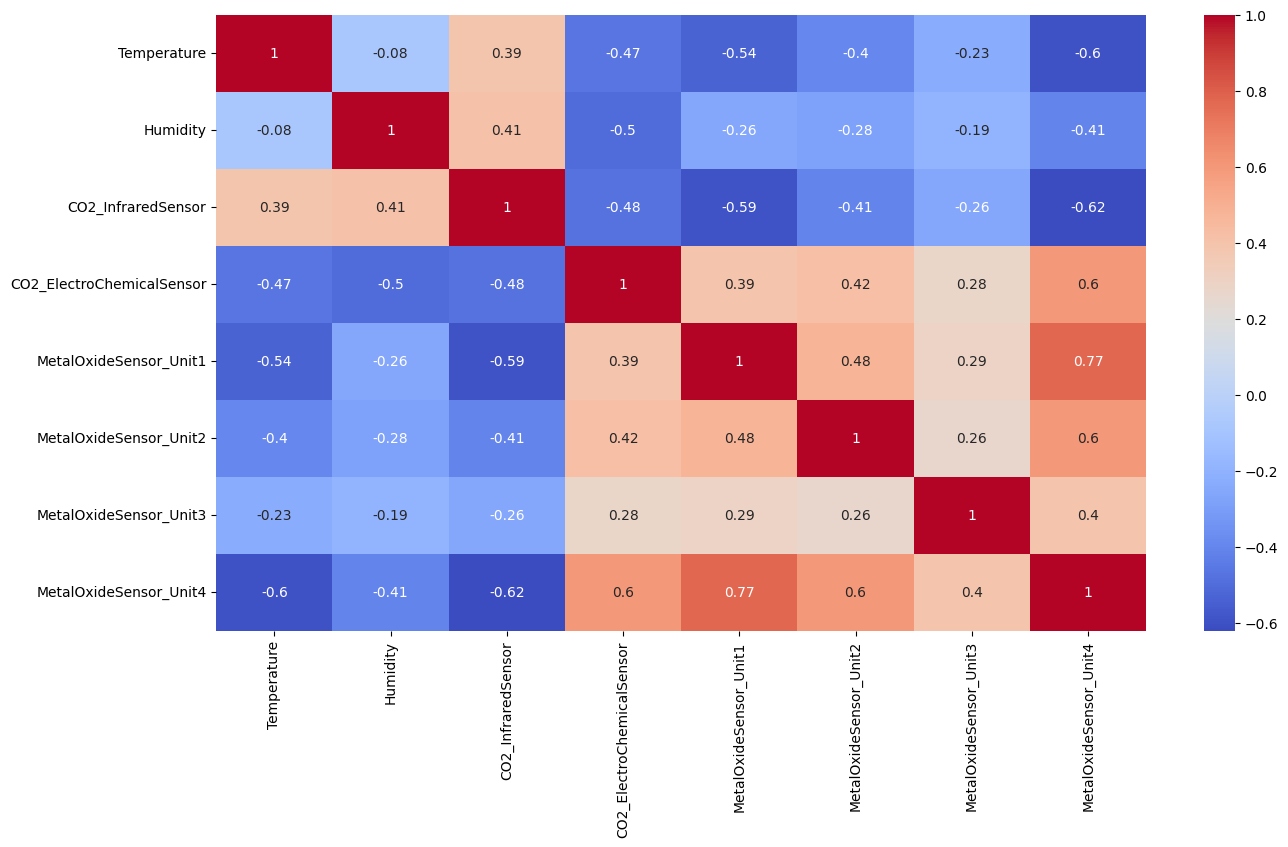

In [12]:
#plot correlation for numerical features
plt.figure(figsize=(15,8))
sns.heatmap(df.select_dtypes(include=["float"]).corr(),annot=True,cmap="coolwarm");

#### **Key Observations for Heatmap (numerical features):**

This heatmap provides a clear view of the linear relationships between the numerical variables:

*   **Redundancy in Metal Oxide Sensors:** The positive correlations (0.77) between `MetalOxideSensor_Unit1`, `Unit4` indicate some kind of multicollinearity suggests they capture similar information, and using them in a model could be redundant. This 2 features could potentially be combined into 1.

*   **Opposing CO2 Sensor Behavior:** The `CO2_InfraredSensor` and `CO2_ElectroChemicalSensor` are moderately negatively correlated (-0.48). This is a crucial finding, as it implies they may be measuring different aspects of air quality, making both potentially valuable as distinct features.

*   **Impact of Ambient Conditions:** `Temperature` and `Humidity` show moderate correlations with the gas sensors, confirming that changes in ambient conditions influence sensor readings. This is important context for any predictive modeling.

*   **Session ID Confirmed as Irrelevant:** The `Session ID` shows near-zero correlation with all other variables, confirming it is a simple identifier with no value for prediction.

### Step 2: Association Between Categorical Features

  To measure the relationship between categorical variables, we use two key statistical tools: the Chi-Squared Test and
  Cramer's V.

   * Chi-Squared Test of Independence:
       * Determines if a statistically significant association exists between two categorical variables.
       * It compares the observed frequencies in a contingency table with the frequencies that would be
         expected if the variables were independent.
       * A low p-value suggests the relationship is statistically significant and not
         due to random chance.

   * Cramer's V:
       * Measures the strength of the association after a significant Chi-Squared test.
       * It produces a value between 0 and 1, where 0 indicates no association and 1 indicates a perfect
         association.
       * Higher values signify a stronger relationship.

In [13]:
def run_pairwise_chi_square(df):
    """
    Performs Chi-Squared test then calculates Cramer's V for all unique
    pairs of categorical features.
    
    input: pd.Dataframe

    Returns: pd.DataFrame: Results for each pair.
    """
    
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    if not categorical_cols:
        print("No categorical columns found in the DataFrame.")
        return pd.DataFrame()

    results = []
    # Get all unique pairs of categorical features
    for col1, col2 in combinations(categorical_cols, 2):
        # Create a contingency table
        contingency_table = pd.crosstab(df[col1], df[col2])
        
        # Ensure table is not empty before running the test
        if contingency_table.empty:
            continue

        # Run the Chi-Squared test
        chi2_statistic, p_value, dof, expected_frequencies = chi2_contingency(contingency_table)

        # Calculate association value (Cramer's V)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        
        # Handle cases where min_dim is 0 (i.e., one variable has only 1 category)
        cramers_v = np.nan
        if min_dim > 0:
            cramers_v = np.sqrt(chi2_statistic / (n * min_dim))
        
        # Store the results
        results.append({
            'Feature_1': col1,
            'Feature_2': col2,
            'Chi2_Statistic': chi2_statistic,
            'P_Value': p_value,
            'Degrees_of_Freedom': dof,
            'Cramers_V': cramers_v,
            'Significant_Association': 'Yes' if p_value < 0.05 else 'No'
        })

    # Convert the results to a DataFrame for a clean, tabular presentation
    results_df = pd.DataFrame(results)
    return results_df

In [14]:
pairwise_results = run_pairwise_chi_square(df)

if not pairwise_results.empty:
    print("\n--- Pairwise Chi-Squared Test Results ---")
    # Sort by Cramer's V to see the strongest associations first
    sorted_results = pairwise_results.sort_values(by='Cramers_V', ascending=False)
    
    # Format the output for better readability
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    display(sorted_results.round(4))

    # Provide a summary of the findings
    print("\n--- Summary of Findings ---")
    strongest_association = sorted_results.iloc[0]
    print(f"The strongest association is between '{strongest_association['Feature_1']}' and '{strongest_association['Feature_2']}',")
    print(f"with a Cramer's V of {strongest_association['Cramers_V']:.4f}.")
    
    significant_pairs = sorted_results[sorted_results['Significant_Association'] == 'Yes']
    if not significant_pairs.empty:
        print("\nPairs with a statistically significant association (p < 0.05):")
        for index, row in significant_pairs.iterrows():
            print(f"- {row['Feature_1']} and {row['Feature_2']} (Cramer's V: {row['Cramers_V']:.4f})")
    else:
        print("\nNo statistically significant associations were found.")


--- Pairwise Chi-Squared Test Results ---


,Feature_1,Feature_2,Chi2_Statistic,P_Value,Degrees_of_Freedom,Cramers_V,Significant_Association
6,CO_GasSensor,Activity Level,767.1467,0.0000,8,0.2192,Yes
0,Time of Day,CO_GasSensor,1083.1535,0.0000,12,0.2127,Yes
3,Time of Day,Activity Level,295.3556,0.0000,6,0.1360,Yes
7,HVAC Operation Mode,Ambient Light Level,43.0981,0.0020,20,0.0367,Yes
1,Time of Day,HVAC Operation Mode,31.2213,0.0082,15,0.0361,Yes
8,HVAC Operation Mode,Activity Level,12.5330,0.2510,10,0.0280,No
2,Time of Day,Ambient Light Level,18.6064,0.0985,12,0.0279,No
5,CO_GasSensor,Ambient Light Level,15.1129,0.5164,16,0.0218,No
4,CO_GasSensor,HVAC Operation Mode,11.3132,0.9377,20,0.0188,No
9,Ambient Light Level,Activity Level,3.1961,0.9215,8,0.0141,No



--- Summary of Findings ---
The strongest association is between 'CO_GasSensor' and 'Activity Level',
with a Cramer's V of 0.2192.

Pairs with a statistically significant association (p < 0.05):
- CO_GasSensor and Activity Level (Cramer's V: 0.2192)
- Time of Day and CO_GasSensor (Cramer's V: 0.2127)
- Time of Day and Activity Level (Cramer's V: 0.1360)
- HVAC Operation Mode and Ambient Light Level (Cramer's V: 0.0367)
- Time of Day and HVAC Operation Mode (Cramer's V: 0.0361)


**Key observations:**

  1. Associations with the Target Variable (`Activity Level`)

   * Strongest Predictors: The features most significantly associated with Activity Level are:
       * `CO_GasSensor` (Cramer's V: 0.1572): This is the strongest categorical predictor, indicating a clear link
         between the gas sensor's state and the resident's activity.
       * `Time of Day` (Cramer's V: 0.1122): This feature also shows a statistically significant, though weaker,
         association.

   * Non-Predictive Features: The following features show no statistically significant relationship with Activity Level
     and may be poor predictors on their own:
       * `HVAC Operation Mode` (p-value: 0.4455)
       * `Ambient Light Level` (p-value: 0.9896)

  2. Multicollinearity Among Predictor Variables

   * Moderate Association: A notable association exists between two of the key predictors:
       * `Time of Day` and `CO_GasSensor` (Cramer's V: 0.2105):
         - This is the strongest association among all categorical
         pairs, suggesting they share a moderate amount of information. While this could affect the interpretability of
         some models (like linear regression), it is generally well-handled by tree-based algorithms.

  3. Implications for Machine Learning

   * Feature Selection: `CO_GasSensor` and `Time of Day` should be prioritized as the most promising categorical features for
     predicting Activity Level.
   * Feature Engineering: Since HVAC Operation Mode and Ambient Light Level show no direct association with the target,
     they could be excluded or engineered into more informative features.

### Step 3: Analysis of Variance (ANOVA)

To measure the relationship between numerical and categorical features, we use twp statistical tools: ANOVA and Eta-squared.


* ANOVA:
   * Determines if a statistically significant association exists between a numerical and categorical variable.
   * It is done by partitioning the total variance in the data into components attributable to different sources and then conducting a F-test.
   * A low p-value suggests the relationship is statistically significant and not
     due to random chance.

* Eta-squared:
   * Measures the strength of the rekationship after a significant F-test in ANOVA.
   * It produces a value between 0 and 1 where a higher value indicates a larger proportion of variance explained by the pair.


In [15]:
def anova_summary(df, alpha=0.05):
    """
    Run one-way ANOVA for every numeric vs. categorical feature pair,
    compute F, p, and eta-squared, and return a summary DataFrame.
    """
    # identify columns
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    
    results = []
    for cat in cat_cols:
        # skip too few groups
        levels = df[cat].dropna().unique()
        if len(levels) < 2:
            continue
        
        for num in num_cols:
            # prepare the data
            sub = df[[cat, num]].dropna()
            groups = [sub.loc[sub[cat] == lvl, num].values for lvl in levels]
            # need at least 2 values in each group
            if any(len(g) < 2 for g in groups):
                continue
            
            # ANOVA
            F, p = f_oneway(*groups)
            
            # effect size (eta-squared)
            grand_mean = sub[num].mean()
            ssb = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups)
            sst = ((sub[num] - grand_mean)**2).sum()
            eta2 = ssb / sst if sst > 0 else np.nan
            
            results.append({
                'Categorical': cat,
                'Numeric': num,
                'F-value': F,
                'p-value': p,
                'Eta-squared': eta2
            })
    
    # build DataFrame, sort by p-value
    res_df = pd.DataFrame(results)
    res_df = res_df.sort_values('p-value').reset_index(drop=True)
    return res_df


In [16]:
# Usage:
anova_df = anova_summary(df)
display(anova_df.style
        .format({'F-value': '{:.2f}', 'p-value': '{:.3g}', 'Eta-squared': '{:.3f}'})
        .set_caption("ANOVA Results: Numeric vs Categorical Features"))


,Categorical,Numeric,F-value,p-value,Eta-squared
0,Time of Day,Temperature,2996.59,0,0.530
1,Time of Day,Humidity,596.31,0,0.183
2,Time of Day,MetalOxideSensor_Unit4,711.39,0,0.211
3,Time of Day,MetalOxideSensor_Unit1,740.24,0,0.218
4,CO_GasSensor,CO2_ElectroChemicalSensor,471.60,0,0.191
5,CO_GasSensor,MetalOxideSensor_Unit1,1043.62,0,0.344
6,CO_GasSensor,CO2_InfraredSensor,597.00,0,0.230
7,CO_GasSensor,Temperature,442.94,0,0.182
8,CO_GasSensor,MetalOxideSensor_Unit2,428.28,0,0.177
9,CO_GasSensor,MetalOxideSensor_Unit4,1411.25,0,0.414


**Key observations (Activity Level):**

Top Predictors:

- `MetalOxideSensor_Unit4` (Eta-squared = 0.159): Strongest single‐feature separator of activity classes

- `CO2_ElectroChemicalSensor` (Eta-squared = 0.123): Higher electrochemical CO₂ levels align with increased activity

- `Temperature` (Eta-squared = 0.096): Higher ambient temperatures tend to coincide with higher activity

- `MetalOxideSensor_Unit1` (Eta-squared = 0.093): Unit 1 readings also show clear shifts across activity levels.

Moderate Predictors:

- `CO2_InfraredSensor` (Eta-squared = 0.081)

- `MetalOxideSensor_Unit2` (Eta-squared = 0.067)

- `Humidity` (Eta-squared = 0.040)

- `MetalOxideSensor_Unit3` (Eta-squared = 0.032)
    

Weak Predictors:

- `Session ID` (Eta-squared = 0.003)

- `HVAC Operation Mode` (Eta-squared ≈ 0)

- `Ambient Light Level` (Eta-squared ≈ 0)


---
This analysis showed the top features with relatively higher predicting power should be used as primary features in subsequent modelling. As for the other moderate predictors, there is a need for further consideration as they could still be valuable by combining or doing some transformation. Lastly, for weak predictors, they should be dropped to avoid noise and redundancy.


## 
<b> Conclusion: <b/>

This EDA was conducted to understand the relationships between smart home sensor data and the activity levels of an elderly resident. we successfully transformed a raw dataset into a clean, reliable foundation for machine learning, yielding clear, actionable insights for feature selection and model development.

  1. **Data Quality and Cleaning:**

     The initial dataset of 10,000 records contained significant issues, including duplicates, physically impossible values (e.g., negative humidity, extreme temperatures), and inconsistent categorical formatting. Through a rigorous cleaning process which involved removing duplicates, standardizing categories, imputing missing values, and filtering outliers, the dataset was refined to 7,983 high-quality records, ensuring the reliability of the subsequent analysis.

---


  2. **Key Predictors of Activity Level:**
  
      The primary goal was to identify which environmental factors correlate with Activity Level. The analysis conclusively identified a set of strong predictors:

     1) Based on ANOVA, the features whose mean values differ most significantly across activity levels are `MetalOxideSensor_Unit4`, `CO2_ElectroChemicalSensor` and `Temperature`. These are the most powerful numerical indicators of `Activity Level`.  



     2) The Chi-Squared test confirmed that `CO_GasSensor` and `Time of Day` are the categorical features most significantly associated with changes in `Activity Level`.

---

  3. **Feature Relationships and Redundancy:**

     The analysis also uncovered critical relationships between the sensor features themselves:
       * Redundancy: A strong positive correlation between `MetalOxideSensor_Unit1` and `MetalOxideSensor_Unit1` suggests they are largely redundant and could be combined.
       * Unique Information: The negative correlation between the `CO2_InfraredSensor` and `CO2_ElectroChemicalSensor` indicates they capture different aspects of air quality, making both potentially valuable.
       * Weak Predictors: `HVAC Operation Mode` and `Ambient Light Level` showed no significant statistical relationship with `Activity Level` and can be deprioritized.

---

Based on these findings, the following can be considered for ML development phase:

   1. Feature Selection:
       * Core Features: Build the initial model using the strongest predictors: `MetalOxideSensor_Unit4`, `CO2_ElectroChemicalSensor`, `Temperature`, `CO_GasSensor`, and `Time of Day`.
       * Exclude: Drop `Session ID`, `HVAC Operation Mode`, and `Ambient Light Level` to create a simpler, more robust model.
   2. Feature Engineering:
       * Could consider vombining the redundant MetalOxideSensor units (e.g., through averaging) to create a single, more stable feature.
   3. Next Steps:
       * Proceed with building a ML model using the recommended feature set.

In [17]:
#Export cleaned data to csv
df.to_csv("data\gas_monitoring_cleaned.csv",index=False)